In [420]:
import collections

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

In [421]:
results = collections.defaultdict(lambda: collections.defaultdict(lambda: [[], [], []]))
with open("/tmp/gridsearch_results.txt", "rt") as f:
    for i, l in enumerate(f):
        if i < 100:
            continue  # Ignore warmup
        
        impl, c_in, c_out, image_h, image_w, delta_ns = [int(i) for i in l.strip().split()]
        results[(image_h, image_w)][(c_in, c_out)][impl].append(delta_ns)

bounds = {
    k: [[np.inf, np.inf], [-np.inf, -np.inf]]
    for k in results
}

for k, r in results.items():
    for c_in, c_out in r:
        bounds[k][0][0] =  min(bounds[k][0][0], c_in)
        bounds[k][0][1] =  min(bounds[k][0][0], c_out)
        bounds[k][1][0] =  max(bounds[k][1][0], c_in)
        bounds[k][1][1] =  max(bounds[k][1][0], c_out)

    assert(bounds[k][0][0] >= 0)
    assert(bounds[k][0][1] >= 0)

In [422]:
border_map = {
    k: np.ones((bounds[k][1][0] + 2, bounds[k][1][1] + 2, 3))
    for k in results
}

for k, r in results.items():
    count = 0
    best_counts = [0, 0, 0]
    max_scale = 3
    for (c_in, c_out), v in r.items():
        if all([len(vi) > 1 for vi in v]):
            v = np.array([np.mean(vi) for vi in v])
#             v = np.array([np.median(vi) for vi in v])
            v -= np.min(v) * 0.8
            v /= np.max(v)
            v *= max_scale
            best_counts[np.argmin(v)] += 1
            count += 1

            border_map[k][c_in, c_out, :] = torch.softmax(max_scale - torch.Tensor(v), dim=0).numpy()
    print(count)
    print(k, best_counts)

8447
(128, 128) [3025, 2226, 3196]


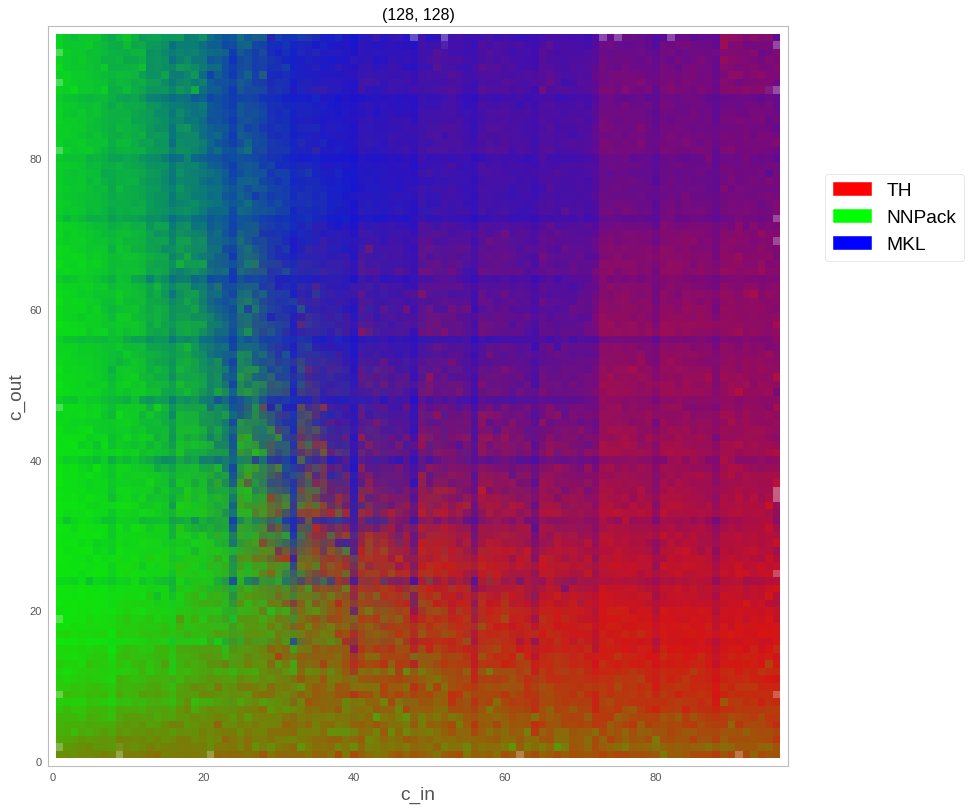

In [425]:
fig = plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
subplot_w = int(np.ceil(np.sqrt(len(results))))
subplot_h = int(np.ceil(len(results) / subplot_w))
for i, (k) in enumerate(sorted(border_map.keys())):
    bm = border_map[k]
    
    # TODO: remove interpolation
    bm = bm.copy()
    ind_to_interpolate = []
    for index_0 in range(1, bm.shape[0] - 1):
        for index_1 in range(1, bm.shape[1] - 1):
            if sum(bm[index_0, index_1, :]) == 3:
                ind_to_interpolate.append((index_0, index_1))
    for index_0, index_1 in ind_to_interpolate * 5:
        bm[index_0, index_1, :] = (
            bm[index_0 - 1, index_1, :] +
            bm[index_0 + 1, index_1, :] +
            bm[index_0, index_1 - 1, :] +
            bm[index_0, index_1 + 1, :]) / 4
    
    plt.subplot(subplot_h, subplot_w, i + 1)
    plt.imshow(bm, interpolation="none", origin="lower")
    plt.grid(None)
    plt.xlabel("c_in", fontsize="xx-large")
    plt.ylabel("c_out", fontsize="xx-large")
    plt.title(str(k))
patches = [mpatches.Patch(color=c, label=l) for c, l in (([1, 0, 0], "TH"), ([0, 1, 0], "NNPack"), ([0, 0, 1], "MKL"))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0. , fontsize="xx-large")
fig.tight_layout()